In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import vectorbt as vbt

### Strategy Initialization

In [2]:
# This is the number of days we will look back to 
# Calculate the rolling z-score
window = 22

# This is the number of standard deviatiojns that the z-score needs to be 
# above or below to trigger a trading signal
thresh = 1.5

# Set the start date to today and the end date to two calendar days ago
today = pd.Timestamp.today().strftime("%Y-%m-%d")
start_date = (pd.Timestamp.today() - pd.Timedelta(days=365*2)).strftime("%Y-%m-%d")

### Data Fetching

In [4]:
# Using Vector BT to download functionality to grab price history data
data = vbt.YFData.download(
    [
        "CL=F",
        "RB=F",
        "HO=F",
        "PSX"
    ],
    start=start_date,
    end=today,
    missing_index="drop"
)

In [5]:
### One more step to extract data out of VectorBT objects
# the data object requires us to extract the data
cl = data.get("Close")["CL=F"]
rb = data.get("Close")["RB=F"]
ho = data.get("Close")["HO=F"]
psx = data.get("Close")["PSX"]

### Calculating the Crack Spread

In [6]:
#Construct crack spread which is defined as long 3 rude oil contracts and short 2 contracts
#of gasoline and short 1 contract of heating oil
crack_spread = 3 * cl - 2 * rb - ho

In [7]:
# create the spread between the crack spread and the refiner's stock price in the same way as before
spread = crack_spread - psx

### Backtesting

In [24]:
# Compute z-score of spread between crack spread and refiner price to normalize the difference
# can use z- score as trading signal

zscore = (
  spread
  - spread.rolling(window=window).mean()
) / spread.rolling(window=window).std()

In [25]:
# using vectorBT to test when the z-score crosses above and below our  thresholds.
long_entries = zscore.vbt.crossed_below(-thresh) # long entriues
long_exits = zscore.vbt.crossed_above(thresh)

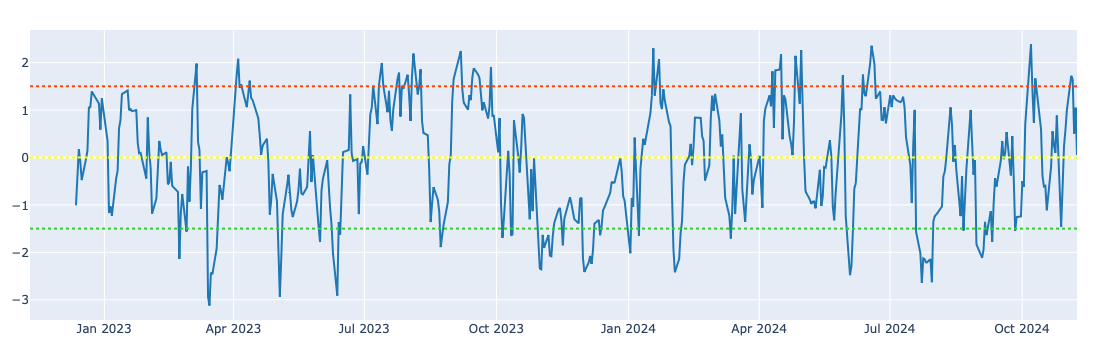

In [26]:
# visualize where the z score lies relative to thresholds
fig = zscore.vbt.plot()
fig.add_hline(y=thresh, line_color="orangered", line_dash="dot")
fig.add_hline(y=0, line_color="yellow", line_dash="dot")
fig.add_hline(y=-thresh, line_color="limegreen", line_dash="dot")
fig.show()

In [28]:
# Run a backtest based on the prices, long, and short entries and exits
perf = vbt.Portfolio.from_signals(
    psx,
    entries=long_entries,
    exits=long_exits,
    freq="1D"
)


<Axes: xlabel='Date'>

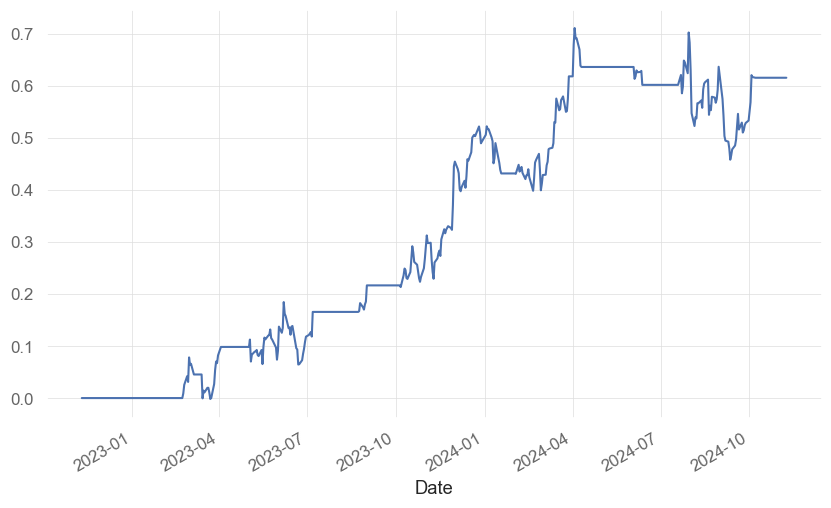

In [29]:
# plot equity curve
perf.cumulative_returns().plot()

In [30]:
#get statistics
perf.stats()

Start                          2022-11-10 05:00:00+00:00
End                            2024-11-08 05:00:00+00:00
Period                                 502 days 00:00:00
Start Value                                        100.0
End Value                                     161.564577
Total Return [%]                               61.564577
Benchmark Return [%]                           27.862807
Max Gross Exposure [%]                             100.0
Total Fees Paid                                      0.0
Max Drawdown [%]                                14.78506
Max Drawdown Duration                  153 days 00:00:00
Total Trades                                           8
Total Closed Trades                                    8
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                        87.5
Best Trade [%]                                 17.684853
Worst Trade [%]                

The backtest shows a total return of 61.5%! We have reason to be a bit suspect of these results since we’re not incorporating things like slippage and commissions